# Предсказание цен на авто

**Описание проекта**

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:
1. Качество предсказания.
2. Скорость предсказания.
3. Время обучения.

**Инструкция по выполнению проекта**

Чтобы усилить исследование, не ограничивайтесь градиентным бустингом. Попробуйте более простые модели — иногда они работают лучше. Это редкие случаи, которые легко пропустить, если всегда применять только бустинг. Поэкспериментируйте и сравните характеристики моделей: скорость работы, точность результата.

План работы:
1. Загрузите и подготовьте данные.
2. Обучите разные модели. Для каждой попробуйте различные гиперпараметры.
3. Проанализируйте скорость работы и качество моделей.
4. Для оценки качества моделей применяйте метрику RMSE.

**Описание данных**

Данные находятся в файле `/datasets/autos.csv`.

Признаки:
1. `DateCrawled` — дата скачивания анкеты из базы
2. `VehicleType` — тип автомобильного кузова
3. `RegistrationYear` — год регистрации автомобиля
4. `Gearbox` — тип коробки передач
5. `Power` — мощность (л. с.)
6. `Model` — модель автомобиля
7. `Kilometer` — пробег (км)
8. `RegistrationMonth` — месяц регистрации автомобиля
9. `FuelType` — тип топлива
10. `Brand` — марка автомобиля
11. `NotRepaired` — была машина в ремонте или нет
12. `DateCreated` — дата создания анкеты
13. `NumberOfPictures` — количество фотографий автомобиля
14. `PostalCode` — почтовый индекс владельца анкеты (пользователя)
15. `LastSeen` — дата последней активности пользователя

Целевой признак:
1. `Price` — цена (евро)

In [1]:
import pandas as pd
import numpy as np
import miceforest as mf
import optuna
import plotly.express as px

from caseconverter import snakecase
from ydata_profiling import ProfileReport
from IPython.display import display
from collections import defaultdict

from fast_ml import eda

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import KNNImputer

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

from sklearn.metrics import mean_squared_error

In [2]:
FIG_WIDTH = 10 * 100
FIG_HEIGHT = 5 * 100
RANDOM_SEED = 42

In [3]:
try:
    raw_autos = pd.read_csv('autos.csv')
except:
    raw_autos = pd.read_csv('/datasets/autos.csv')

## Исследовательский анализ данных

Изучим основные зависимости в данных перед тем, как мы будем использовать их в алгоритмах машинного обучения.

Таблица-резюме:

In [4]:
display(eda.df_info(raw_autos))

,data_type,data_type_grp,num_unique_values,sample_unique_values,num_missing,perc_missing
DateCrawled,object,Categorical,271174,"[2016-03-24 11:52:17, 2016-03-24 10:58:45, 201...",0,0.0
Price,int64,Numerical,3731,"[480, 18300, 9800, 1500, 3600, 650, 2200, 0, 1...",0,0.0
VehicleType,object,Categorical,8,"[nan, coupe, suv, small, sedan, convertible, b...",37490,10.579368
RegistrationYear,int64,Numerical,151,"[1993, 2011, 2004, 2001, 2008, 1995, 1980, 201...",0,0.0
Gearbox,object,Categorical,2,"[manual, auto, nan]",19833,5.596709
Power,int64,Numerical,712,"[0, 190, 163, 75, 69, 102, 109, 50, 125, 101]",0,0.0
Model,object,Categorical,250,"[golf, nan, grand, fabia, 3er, 2_reihe, other,...",19705,5.560588
Kilometer,int64,Numerical,13,"[150000, 125000, 90000, 40000, 30000, 70000, 5...",0,0.0
RegistrationMonth,int64,Numerical,13,"[0, 5, 8, 6, 7, 10, 12, 11, 2, 3]",0,0.0
FuelType,object,Categorical,7,"[petrol, gasoline, nan, lpg, other, hybrid, cn...",32895,9.282697


Числовые распределения:

In [5]:
display(round(raw_autos.describe().T, 2))

,count,mean,std,min,25%,50%,75%,max
Price,354369.0,4416.66,4514.16,0.0,1050.0,2700.0,6400.0,20000.0
RegistrationYear,354369.0,2004.23,90.23,1000.0,1999.0,2003.0,2008.0,9999.0
Power,354369.0,110.09,189.85,0.0,69.0,105.0,143.0,20000.0
Kilometer,354369.0,128211.17,37905.34,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,354369.0,5.71,3.73,0.0,3.0,6.0,9.0,12.0
NumberOfPictures,354369.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0
PostalCode,354369.0,50508.69,25783.10,1067.0,30165.0,49413.0,71083.0,99998.0


И детальный отчет:

In [6]:
ProfileReport(raw_autos).to_widgets()

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

На основе предоставленных выводов, вот некоторые предварительные наблюдения:

**Пропущенные данные:** 
1. Колонки `VehicleType`, `Gearbox`, `Model`, `FuelType`, и `Repaired` имеют пропущенные значения. Колонка `Repaired` имеет наибольшее количество пропущенных значений, 20% данных отсутствует.

**Типы данных и уникальные значения:** 
1. Датасет содержит как категориальные (тип `object`), так и числовые (тип `int64`) переменные. 
2. Колонка `NumberOfPictures` содержит только одно уникальное значение - 0, которое не предоставляет полезной информации для модели.

**Дескриптивная статистика:**
1. Колонка `Price` (наша целевая переменная) варьируется от 0 до 20000, со средним значением около 4416.66. Это указывает на широкий диапазон цен на автомобили в наборе данных. Тот факт, что минимальная цена равна 0, может потребовать дополнительного исследования, так как необычно, чтобы цена автомобиля была 0.
2. Колонка `RegistrationYear` варьируется от 1000 до 9999, что не имеет смысла, поскольку автомобили были изобретены только в конце 19-го века, а год 9999 находится в далеком будущем. Эта колонка может требовать очистки данных.
3. Колонка `Power` имеет максимальное значение 20000, что кажется чрезмерно высоким и, вероятно, указывает на некоторые ошибочные записи.
4. Колонка `Kilometer` кажется сильно смещенной в сторону более высоких значений, с 75% автомобилей, пробег которых составляет 150000 км.

# Подготовка данных для ML

Выполним эти преобразования на полном датасете:

1. Уберем колонки, которые не влияют на предсказания: `DateCrawled`, `DateCreated`, `LastSeen`, `PostalCode`, `NumberOfPictures`.
2. Названия колонок приведем `snake_case` регистру.
3. Обрежем строки, которые не имеют бизнес-смысла или если мы их можем восстановить.

И остальные после разделения на выборки, чтобы избежать data leakage:

1. Заполним пропуски.
2. Проведем стандартизацию численных признаков.
3. Проведем кодирование категориальных признаков.

In [23]:
df_autos = (
    raw_autos
    .copy()
    .drop(['DateCrawled', 'DateCreated', 'LastSeen', 'PostalCode', 'NumberOfPictures'], axis=1)
    .rename(columns=lambda column: snakecase(column))
    .loc[lambda df:
        (df.price > 0) 
        & (df.registration_year.between(1990, 2023))
        & (df.registration_month > 0)
        & (df.power <= 300)
        # & ~(df.vehicle_type.isna())
    ]
    .assign(
        power=lambda df: df.power.replace(0, np.nan),
        is_repaired=lambda df: df.repaired.map({'yes': 1, 'no': 0}),
        is_manual=lambda df: df.gearbox.map({'manual': 1, 'auto': 0})
    )
    .loc[:, [
        'brand', 'vehicle_type', 'model', 'fuel_type', 'is_manual', 'is_repaired',
        'registration_year', 'registration_month', 'power', 'kilometer', 'price'
    ]]
    .astype({
        'brand': 'category', 'vehicle_type': 'category', 'model': 'category', 'fuel_type': 'category',
        'is_manual': 'float', 'is_repaired': 'float', 'registration_year': 'int64', 'registration_month': 'int64',
        'power': 'float', 'kilometer': 'float', 'price': 'float'
    })
)

display(df_autos.head())

,brand,vehicle_type,model,fuel_type,is_manual,is_repaired,registration_year,registration_month,power,kilometer,price
1,audi,coupe,NaN,gasoline,1.0,1.0,2011,5,190.0,125000.0,18300.0
2,jeep,suv,grand,gasoline,0.0,NaN,2004,8,163.0,125000.0,9800.0
3,volkswagen,small,golf,petrol,1.0,0.0,2001,6,75.0,150000.0,1500.0
4,skoda,small,fabia,gasoline,1.0,0.0,2008,7,69.0,90000.0,3600.0
5,bmw,sedan,3er,petrol,1.0,1.0,1995,10,102.0,150000.0,650.0


In [8]:
ProfileReport(df_autos).to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

Посмотрим, сколько строк нам пришлось вырезать:

In [24]:
print(
    'Original number of rows: ', raw_autos.Price.count(), '\n',
    'Cleaned number of rows: ', df_autos.price.count(), '\n',
    'Percentage difference: ', round(100 * (1 - df_autos.price.count() / raw_autos.Price.count()), 2),
    sep=''
)

Original number of rows: 354369
Cleaned number of rows: 300254
Percentage difference: 15.27


Мы отбросили существенное количество записей, однако, выбора у нас нет, потому что восстановить их нельзя.

Создадим классы и функции, которые обработают данные за нас. Начнем с разделения данных на `train` и `valid`.

In [10]:
def split_data(df: pd.DataFrame, target_column: str, test_size: float):
    """
    Split a DataFrame into training and testing datasets.

    This function accepts a DataFrame, the name of the target column, and the proportion of the data 
    to be included in the test split. It returns four DataFrames: the training features, the training target, 
    the testing features, and the testing target. The target datasets are DataFrames with a single column rather 
    than Series objects.

    Parameters
    ----------
    df : pd.DataFrame
        The DataFrame to split. This DataFrame should include both the features and the target.

    target_column : str
        The name of the target column. This column will be separated from the features and returned 
        in the target DataFrames.

    test_size : float
        The proportion of the data to include in the test split. For example, if `test_size` is 0.3, 
        30% of the data will be used for the test split, and the rest will be used for the training split.

    Returns
    -------
    list of pd.DataFrame
        A list containing four DataFrames: the training features, the training target, 
        the testing features, and the testing target.
    """
    df_train, df_test = train_test_split(
        df, test_size=test_size, random_state=RANDOM_SEED
    )
    
    ftr_train = df_train.drop(target_column, axis=1)
    tgt_train = df_train[[target_column]]
    ftr_test = df_test.drop(target_column, axis=1)
    tgt_test = df_test[[target_column]]
    
    return [ftr_train, tgt_train, ftr_test, tgt_test]

In [16]:
dct_splits = {
    'train': {'features': split_data(df_autos, 'price', 0.1)[0], 'target': split_data(df_autos, 'price', 0.1)[1]},
    'test': {'features': split_data(df_autos, 'price', 0.1)[2], 'target': split_data(df_autos, 'price', 0.1)[3]},
}

А теперь сделаем `pipeline` для подготовки данных, прежде, чем начнем использовать модели.

Пропуски заполним с помощью библиотеки `miceforest`. Она использует Multiple Imputation by Chained Equations (MICE) c lightgbm - это позволит нам восстановить некоторые трудно доступные значения типа `model` и `fuel_type`.

In [32]:
df_complete.head()

,brand,vehicle_type,model,fuel_type,is_manual,is_repaired,registration_year,registration_month,power,kilometer
56163,mercedes_benz,sedan,c_klasse,petrol,1.0,0.0,2003,4,143.0,40000.0
218770,volkswagen,bus,touran,gasoline,0.0,1.0,2006,5,140.0,150000.0
59299,bmw,wagon,3er,petrol,0.0,0.0,2007,11,170.0,90000.0
120994,bmw,sedan,5er,petrol,1.0,0.0,1996,12,170.0,150000.0
148214,peugeot,convertible,3_reihe,gasoline,0.0,0.0,2012,9,163.0,90000.0


In [ ]:
cols_num = ['registration_year', 'registration_month', 'power', 'kilometer']
cols_cat = ['brand', 'vehicle_type', 'model', 'fuel_type']
cols_bin = ['is_manual', 'is_repaired']

impute_kernel = mf.ImputationKernel(dct_splits['train']['features'], datasets=1)

impute_pipeline = Pipeline([
    ('impute', impute_kernel)
])

num_pipeline = Pipeline([
    ('scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore')),
])

preprocessor = ColumnTransformer([
    ('impute', impute_pipeline, cols_cat+cols_bin),
    ('num', num_pipeline, cols_num),
    ('cat', cat_pipeline, cols_cat),
])

preprocessor.fit(dct_splits['train']['features'])

In [25]:
# Create kernel. 
kds = mf.ImputationKernel(
  dct_splits['train']['features'],
  save_all_iterations=True,
  random_state=RANDOM_SEED
)

# Run the MICE algorithm for 2 iterations
kds.mice(2)

# Return the completed dataset.
df_complete = kds.complete_data()

x:\1_Programs\Coding\Conda\lib\site-packages\miceforest\ImputationKernel.py:371: UserWarning: [brand,model,fuel_type] have very rare categories, it is a good idea to group these, or set the min_data_in_leaf parameter to prevent lightgbm from outputting 0.0 probabilities.
  warn(


In [31]:
# ProfileReport(df_complete).to_widgets()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 251465 entries, 56163 to 154542
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   brand               251465 non-null  category
 1   vehicle_type        251465 non-null  category
 2   model               251465 non-null  category
 3   fuel_type           251465 non-null  category
 4   is_manual           251465 non-null  float64 
 5   is_repaired         251465 non-null  float64 
 6   registration_year   251465 non-null  int64   
 7   registration_month  251465 non-null  int64   
 8   power               251465 non-null  float64 
 9   kilometer           251465 non-null  float64 
dtypes: category(4), float64(4), int64(2)
memory usage: 22.7 MB


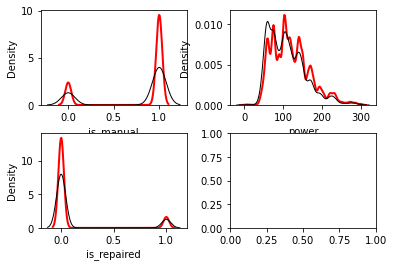

In [26]:
kds.plot_imputed_distributions(wspace=0.3,hspace=0.3)

In [27]:
df_complete

,brand,vehicle_type,model,fuel_type,is_manual,is_repaired,registration_year,registration_month,power,kilometer
56163,mercedes_benz,sedan,c_klasse,petrol,1.0,0.0,2003,4,143.0,40000.0
218770,volkswagen,bus,touran,gasoline,0.0,1.0,2006,5,140.0,150000.0
59299,bmw,wagon,3er,petrol,0.0,0.0,2007,11,170.0,90000.0
120994,bmw,sedan,5er,petrol,1.0,0.0,1996,12,170.0,150000.0
148214,peugeot,convertible,3_reihe,gasoline,0.0,0.0,2012,9,163.0,90000.0
...,...,...,...,...,...,...,...,...,...,...
151885,seat,small,ibiza,petrol,1.0,0.0,2003,8,75.0,150000.0
328740,mitsubishi,suv,other,petrol,1.0,0.0,2011,11,117.0,50000.0
167296,honda,coupe,cr_reihe,petrol,1.0,0.0,1995,6,125.0,90000.0
186273,opel,sedan,insignia,gasoline,0.0,0.0,2010,9,160.0,100000.0
